# Description of the dataset and the task
- Data Collection
- Implications on the types of conclusions that could be made from the data
- Description of the variables, observations, and/or structure of the data
- Target task

In [154]:
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import dask.bag as bag
from dask.diagnostics import ProgressBar

In [155]:
# Create a list with the filepaths for training and testing
batch_size = 32
img_height = 224
img_width = 224

train_path = Path('dataset/train')
test_path = Path('dataset/test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, 
    validation_split=0.2, 
    subset="training", 
    seed=123, 
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, 
    seed=123, 
    image_size=(img_height, img_width))

class_names = train_ds.class_names
print(class_names)
print(len(class_names))

Found 3630 files belonging to 33 classes.
Using 2904 files for training.
Found 3630 files belonging to 33 classes.
Using 726 files for validation.
Found 330 files belonging to 33 classes.
['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
33


In [156]:
class_names = np.array(train_ds.class_names)
print(class_names)

['apple' 'banana' 'beetroot' 'bell pepper' 'cabbage' 'carrot'
 'cauliflower' 'chilli pepper' 'corn' 'cucumber' 'eggplant' 'garlic'
 'ginger' 'grapes' 'jalepeno' 'kiwi' 'lemon' 'lettuce' 'mango' 'onion'
 'orange' 'pear' 'peas' 'pineapple' 'pomegranate' 'potato' 'raddish'
 'soy beans' 'spinach' 'sweetpotato' 'tomato' 'turnip' 'watermelon']


In [157]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


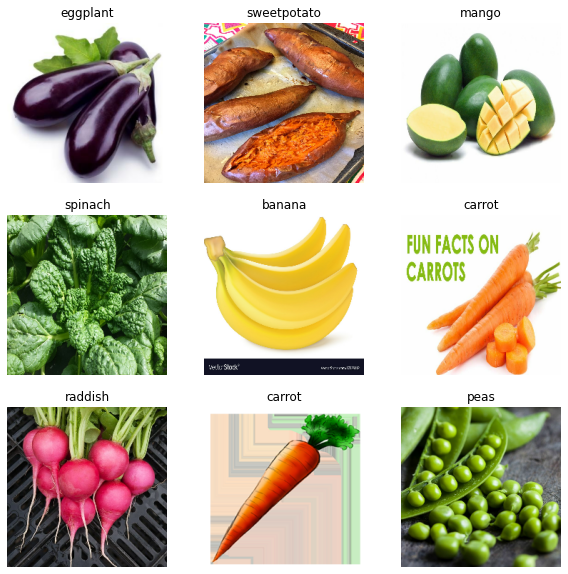

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Exploratory data analysis

This block of code initializes file paths for the folders and images that are going to be used for the exploratory data analysis.

In [159]:
train_dir = Path('dataset/train')
train_filepaths_jpg = list(train_dir.rglob(r'**/*.jpg'))
train_filepaths_jpeg = list(train_dir.rglob(r'**/*.jpeg'))
train_filepaths_png = list(train_dir.rglob(r'**/*.png'))
train_filepaths = train_filepaths_jpg + train_filepaths_jpeg + train_filepaths_png


def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
train_df = train_df.sort_values("Label")
labels = train_df["Label"].unique()
labels.sort()
train_df
train_df.loc[train_df["Label"] == label]

i=0
imagePath = {}

for label in labels:
    imagePath[i] = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpg')]
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.png')]
    for j in temp:
        imagePath[i].append(j)
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpeg')]
    for j in temp:
        imagePath[i].append(j)
    i+=1

# Mean Image
The following code blocks are to obtain the mean image from each fruit and vegetable by converting the image data into a matrix of values per pixel. Each image is then compared to each other to find the mean image for that fruit/vegetable. The mean image can give us some detail in what the model is looking at as it checks pixel data of each image. Knowing this gives us a rough idea of which image should be classified as what class by the model.

In [153]:
# Mean Image
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
i=0
imageMatrix = {}
for label in labels:
    imageMatrix[i] = img2np(f'{train_path}\\{label}\\', imagePath[i])
    i+=1

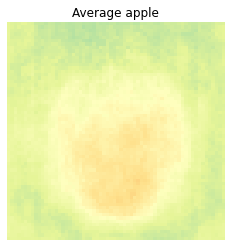

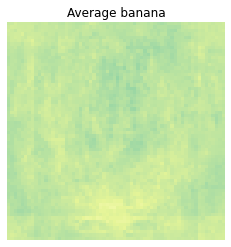

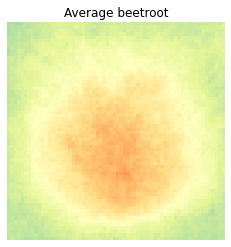

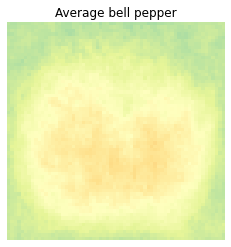

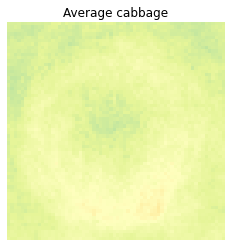

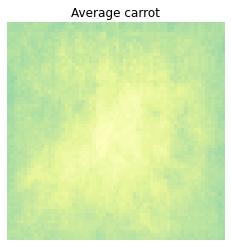

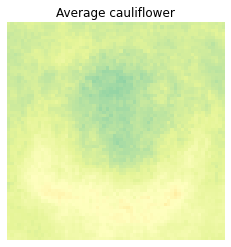

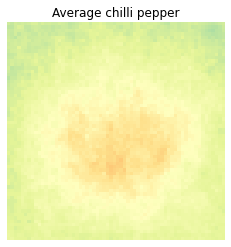

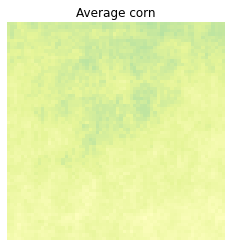

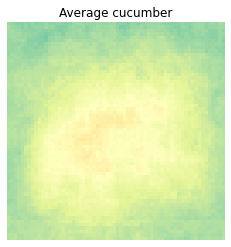

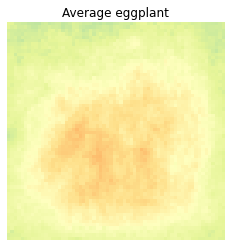

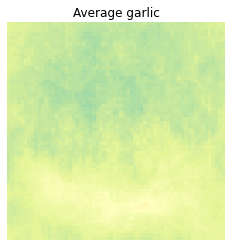

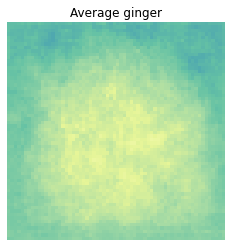

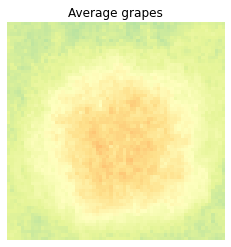

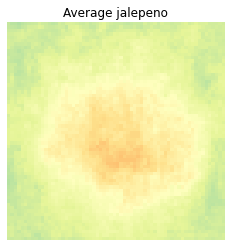

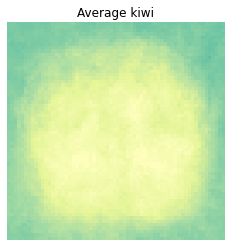

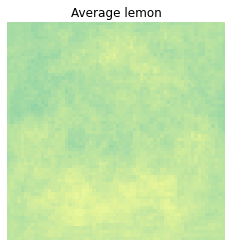

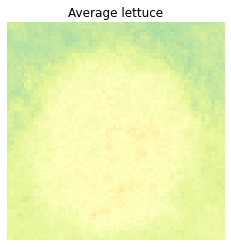

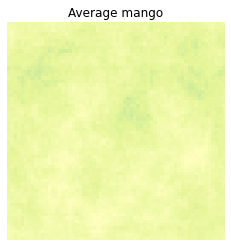

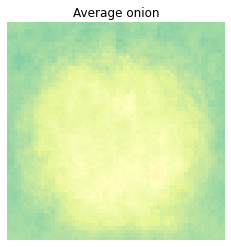

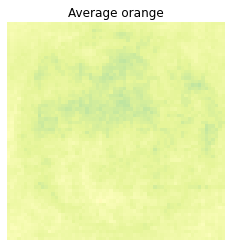

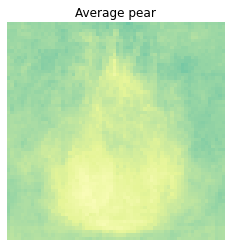

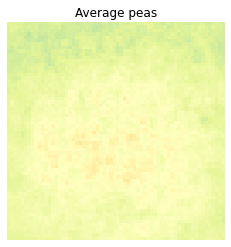

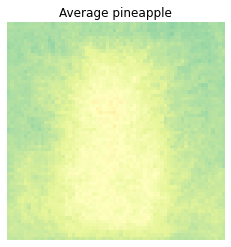

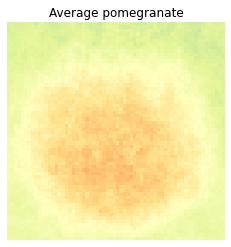

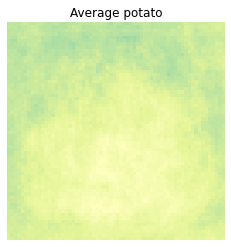

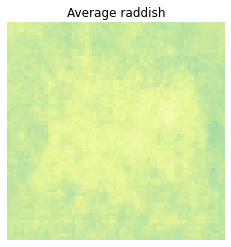

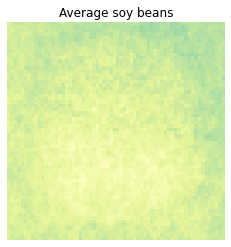

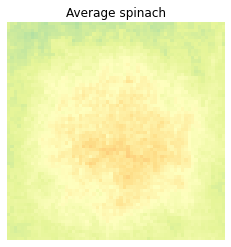

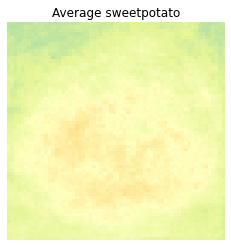

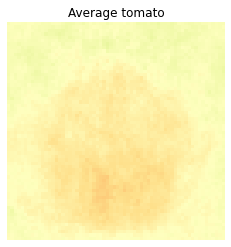

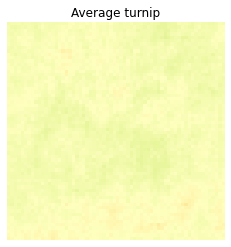

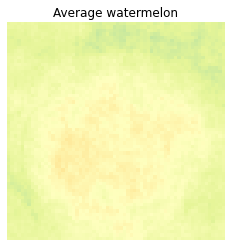

In [115]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    cmap = cm.get_cmap('Spectral')
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap=cmap)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

i=0
means = {}
for label in labels:
    means[i] = find_mean_img(imageMatrix[i], label)
    i+=1

# Distribution of Sizes
The distribution of sizes is shown by obtaining the dimensions of the image namely its height, weight, and depth if it has depth. The height and weight are then compiled into a scatterplot for easy visualization with each fruit and vegetable having its own graph. Knowing the distribution of sizes can help us understand which size is appropriate to be used for pre-processing purposes to normalize the sizes of each image and better tune the model.

In [148]:
# Distribution of Sizes
classDirectories = {}
for label in labels:
    classDirectories[label] = 'dataset/train/' + label + '/'

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if (len(arr.shape) == 3):
        h,w,d = arr.shape
    else:
        h,w = arr.shape
    return h,w

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  5.9s
[########################################] | 100

C:\Users\Allen\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  4.0s


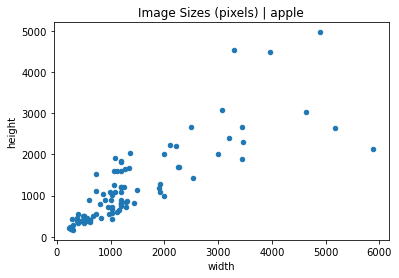

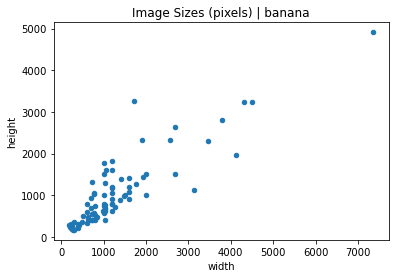

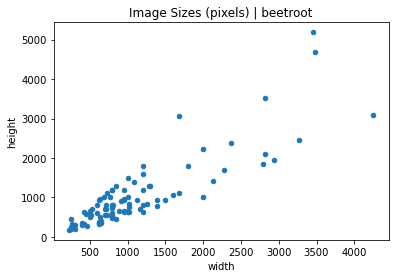

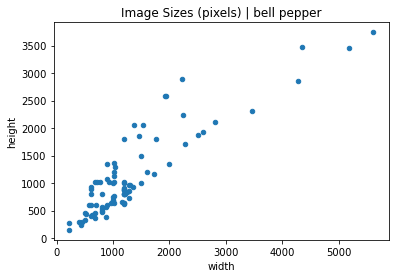

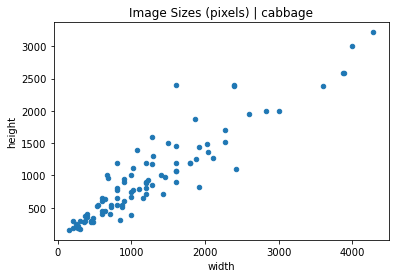

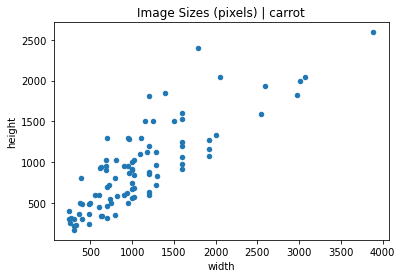

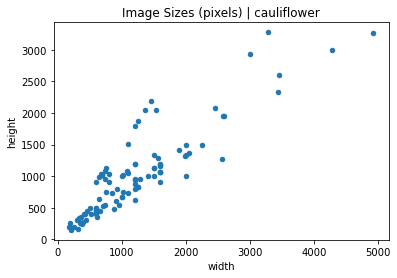

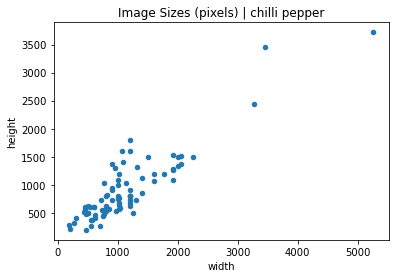

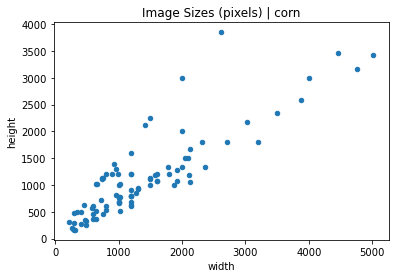

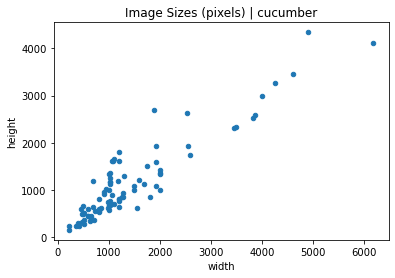

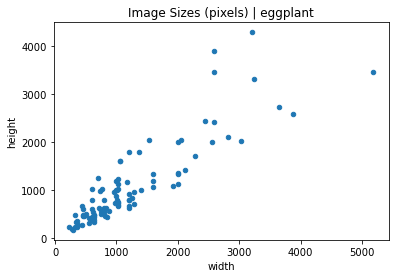

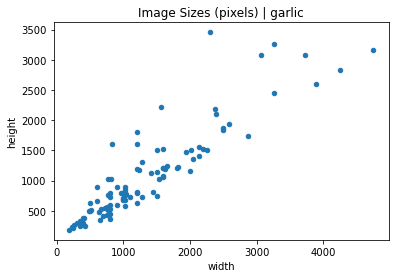

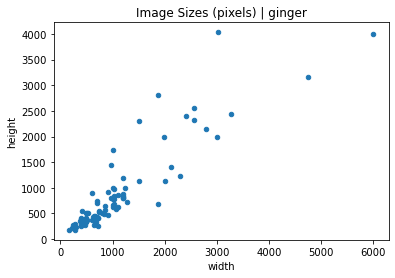

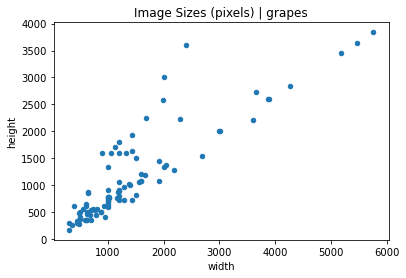

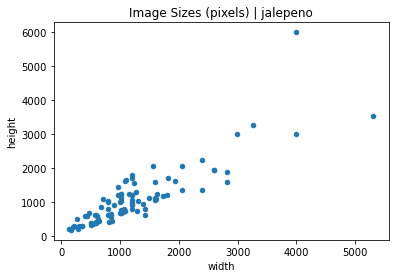

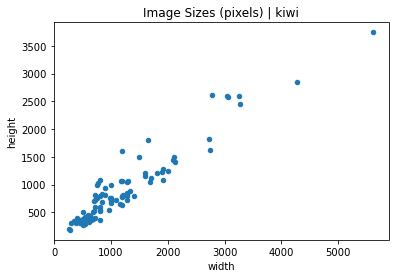

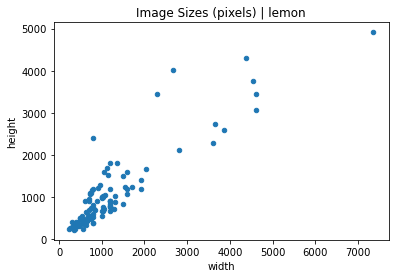

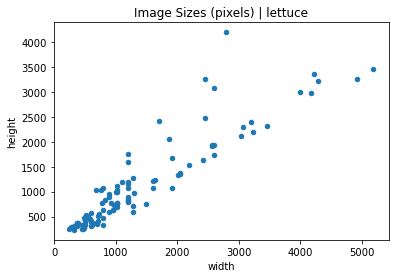

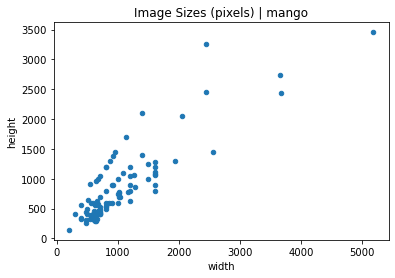

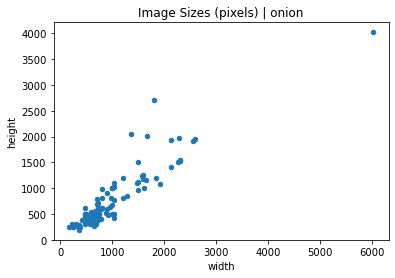

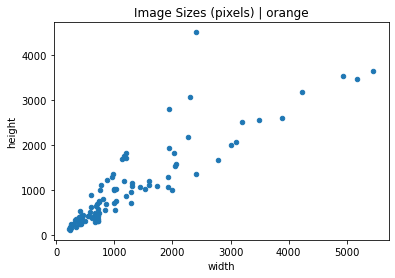

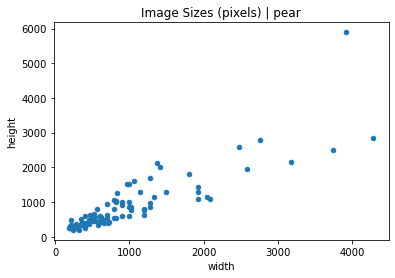

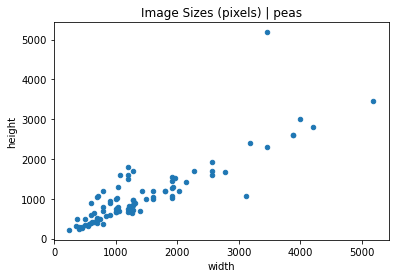

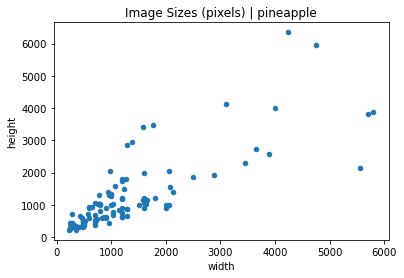

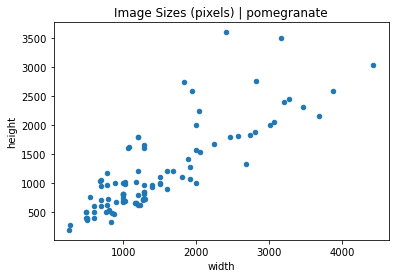

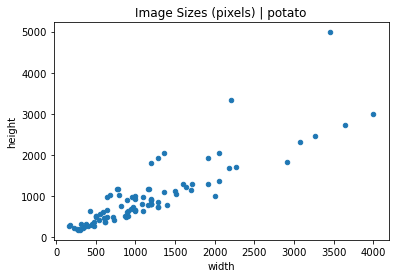

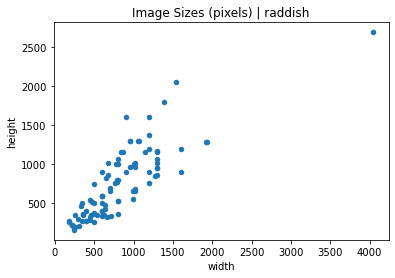

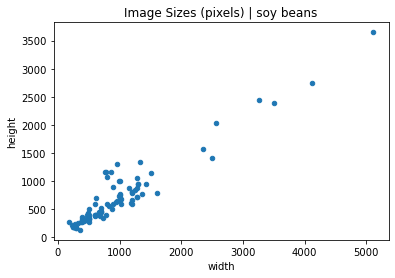

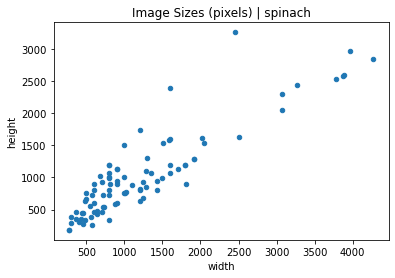

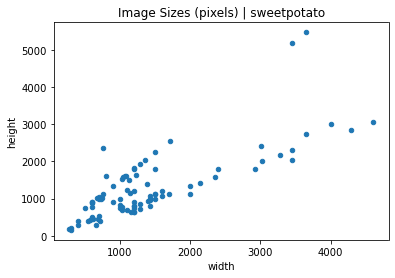

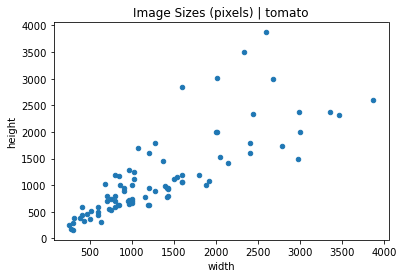

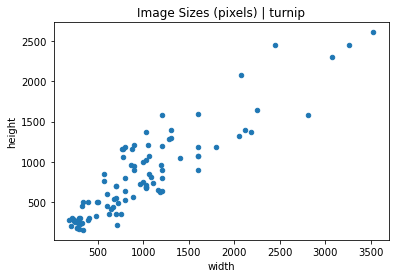

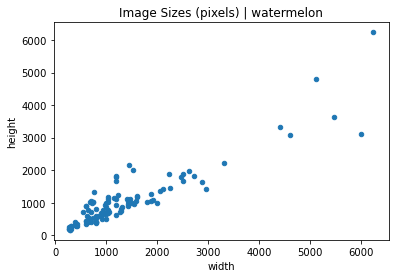

In [149]:
for n,d in classDirectories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

# Distribution of Labels
By checking the directories of each label the amount of images per fruit and vegetable can be shown in a bar graph with number of images in the y-axis and label in the x-axis. Knowing the proper distrubtion of labels can help determine which image has a different count from others. It is important for each label to have the same amount of images as it may affect the training of the model later on.

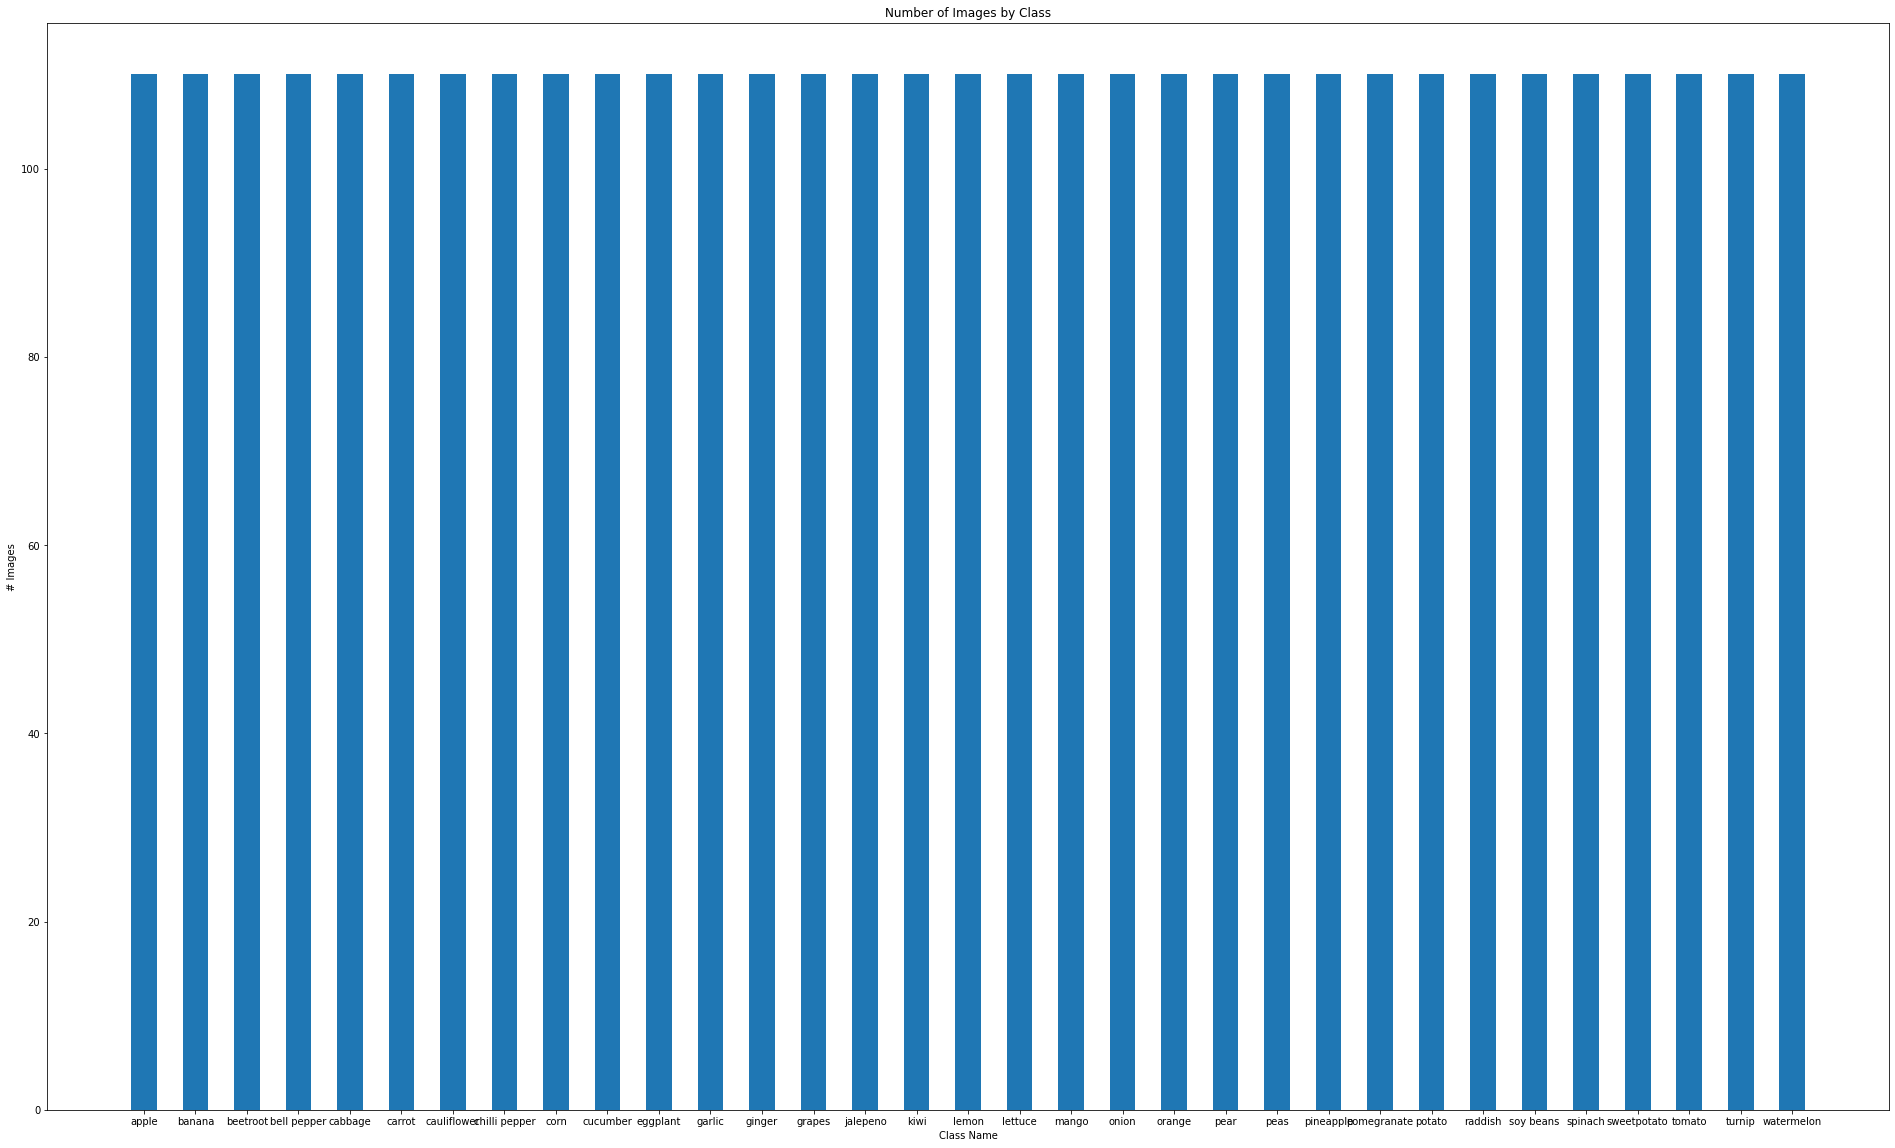

In [160]:
# Distribution of Labels
for label in labels:
    number_classes[label] = len(os.listdir(f'{train_dir}\\{label}'))
f, ax = plt.subplots(figsize=(33,20)) # set the size that you'd like (width, height)
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

# Data Pre-processing and Cleaning
- Change into same dimensions

In [ ]:
# num_classes=33
# IMG_SIZE = 244
# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
#   tf.keras.layers.Rescaling(1./255)
# ])

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
# ])
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(val_ds)
# test_ds = prepare(test_ds)

In [ ]:
# model = tf.keras.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes)
# ])

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# model.summary()

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# loss, acc = model.evaluate(test_ds)
# print("Accuracy", acc)

In [ ]:
# import os
# img = tf.keras.utils.load_img(
#     'Image_110.jpg', target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier_model = mobilenet_v2

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

test_ds = test_ds.shuffle(2)
for test_image_batch, test_labels_batch in test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
result_batch = classifier.predict(train_ds)

In [ ]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
test_ds = test_ds.shuffle(2)
for test_image_batch, test_labels_batch in test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
predicted_batch = model.predict(test_image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(test_image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
t = time.time()

export_path = "saved_models/{}".format(int(t))
model.save(export_path)

export_path

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
# predict on the test dataset
reloaded_result_batch = reloaded.predict(test_image_batch)
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(test_image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

# Model Training

# Model Selection and Hyperparameter Tuning

# Insights and conclusions